In [1]:
import csv
import os
import numpy as np
import pickle
import seaborn as sns
import datetime as d
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
BASE_PATH = './tweets/'

In [3]:
def getTop500TwitterUsers():
    users500 = 'top500accounts.txt'
    names = [];
    with open(users500, 'r') as f:
        for line in f.readlines():
            names.append( line[:-1] )
    return names

def getTweetsOfUser( user ):
    global BASE_PATH
    user_file = os.path.join( BASE_PATH, user + '_tweets.csv' )
    try:
        csv_reader = csv.reader( open( user_file, 'r' ) )
        next(csv_reader, None)  # skip the headers
        PARSE_TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
        first_row = last_row = None
        allT = []
        for row in csv_reader:
            allT.append( {'text':row[2], 'retweet_count':int(row[5]), 'favorite_count':int(row[6]) } )
            if first_row == None:
                first_row = row
            last_row = row
        max_time = d.datetime.strptime( first_row[1], PARSE_TIME_FORMAT )
        min_time = d.datetime.strptime( last_row[1] , PARSE_TIME_FORMAT )
        time_diff = (max_time - min_time).days
        total_tweets = len(allT)
        return [allT, total_tweets/time_diff]
    except:
        return []

def getTop500UserTweets():
    allTweets = {}
    userFrequency = {}
    top500PlusUsers = getTop500TwitterUsers()
    userNumber = 0;
    for user in top500PlusUsers:
        tweetInfo = getTweetsOfUser( user )
        if len(tweetInfo) == 0:
            continue
        allTweets[user] = tweetInfo[0];
        userFrequency[user] = tweetInfo[1]
        userNumber = userNumber + 1;
        if userNumber == 500:
            return [ allTweets, userFrequency ]
    return [ allTweets, userFrequency ]

def get_user_map():
    user_details = pd.read_csv( open('./top500accounts_details.csv', 'r') ).set_index('Name')
    with open('./twitter_user_tnse_result.pickle', 'rb') as f:
        raw_df = pd.DataFrame(pickle.load(f)).transpose()
    raw_df.columns = ["x", "y", "Name"]
    raw_df = raw_df.set_index('Name')
    return raw_df.join(user_details,on='Name',how='left')

In [4]:
[ allTweets, userFrequency ] = getTop500UserTweets()
userDetails = get_user_map()
all_users = [ i for i in userDetails.index if i in allTweets.keys() ]

### <font color='red'>Let's ask some questions now!</font>

### <font color='blue'>1. Do top users tweet more often?</font>

Users with less than 1 tweets per day : 109
Users with atleast 1 tweet per day : 373
Users with more than 10 tweets per day : 142


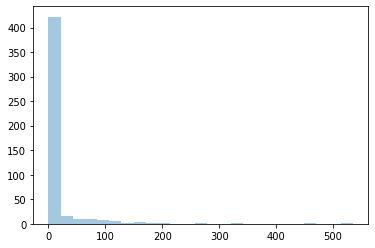

In [5]:
tweet_frequency_value = list(userFrequency.values())
print('Users with less than 1 tweets per day : %d' % ( len( [ x for x in tweet_frequency_value if x < 1 ])) )
print('Users with atleast 1 tweet per day : %d'% ( len( [ x for x in tweet_frequency_value if x >= 1 ])) )
print('Users with more than 10 tweets per day : %d' % ( len( [ x for x in tweet_frequency_value if x > 5 ])) )
sns.distplot(list(userFrequency.values()), bins=25, kde=False);

In [6]:
#### One would expect most users with more than 100 tweets per day to be news channels! Let's check that out
users_with_lot_of_tweets = [ x for x in userFrequency.keys() if userFrequency[x] >= 100 ]
categories = [ (userDetails.loc[user])['category'] for user in users_with_lot_of_tweets ]
print('Percentage of users with more than 100 tweets per day that are "news" is %3.2f' % ( len([x for x in categories if x=='news'])/len(categories)) )

Percentage of users with more than 100 tweets per day that are "news" is 0.91


### <font color='orange'>We see that most of the users ( ~78% ) tweet atleast once per day! We also see that most frequent tweets are the news channels, that is expected! News is the information that gets generated on its own!</font>

### <font color='blue'>2. Do top users have more retweets?</font>

Users with atleast 20000 retweets per post : 13
Users with atleast 1000 retweets per post : 206
Users with atleast 100 retweets per post : 416


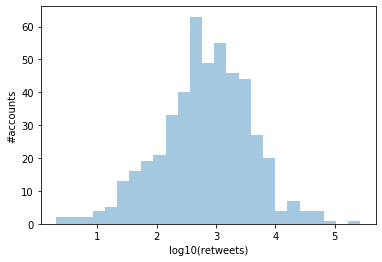

In [7]:
average_user_retweets = [ np.mean( [ x['retweet_count'] for x in allTweets[user] ] ) for user in all_users ]
print('Users with atleast 20000 retweets per post : %d' % ( len( [ x for x in average_user_retweets if x > 20000 ])) )
print('Users with atleast 1000 retweets per post : %d' % ( len( [ x for x in average_user_retweets if x > 1000 ])) )
print('Users with atleast 100 retweets per post : %d'% ( len( [ x for x in average_user_retweets if x > 100 ])) )
sns.distplot( [ np.log10(x) for x in average_user_retweets ], bins=25, kde=False);
plt.xlabel('log10(retweets)')
_ =plt.ylabel('#accounts')

In [8]:
users_with_lot_of_retweets= []
for user in all_users:
    if ( np.mean( [ x['retweet_count'] for x in allTweets[user] ] ) > 20000 ):
        users_with_lot_of_retweets.append(user)
categories = [ (userDetails.loc[user])['category'] for user in users_with_lot_of_retweets ]
print('Percentage of users with more than 20000 retweets per post that are into "music" is %3.2f' % ( len([x for x in categories if x=='music'])/len(categories)) )
region = [ (userDetails.loc[user])['region'] for user in users_with_lot_of_retweets ]
print('Percentage of users with more than 20000 retweets per post that are "american" is %3.2f' % ( len([x for x in region if x=='america'])/len(region)) )
print('Percentage of users with more than 20000 retweets per post that are "england" is %3.2f' % ( len([x for x in region if x=='england'])/len(region)) )

Percentage of users with more than 20000 retweets per post that are into "music" is 0.85
Percentage of users with more than 20000 retweets per post that are "american" is 0.23
Percentage of users with more than 20000 retweets per post that are "england" is 0.31


### <font color='orange'>We see that most of top 500 twitter accounts have around ~800 retweets per post! Of the accounts with most of the retweets, as one would expect, most of them are musicians! The musicians are from america, england and other countries!</font>

### <font color='blue'>3. Do top users have more favourites?</font>

Users with atleast 50000 favorites per post : 12
Users with atleast 10000 favorites per post : 84
Users with atleast 1000 favorites per post : 321


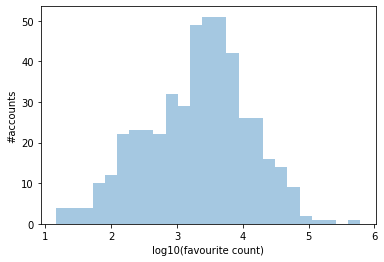

In [9]:
average_user_favourites = [ np.mean( [ x['favorite_count'] for x in allTweets[user] ] ) for user in all_users ]
print('Users with atleast 50000 favorites per post : %d' % ( len( [ x for x in average_user_favourites if x > 50000 ])) )
print('Users with atleast 10000 favorites per post : %d' % ( len( [ x for x in average_user_favourites if x > 10000 ])) )
print('Users with atleast 1000 favorites per post : %d'% ( len( [ x for x in average_user_favourites if x > 1000 ])) )
a = [ np.log10(x) for x in average_user_favourites if x > 10 ] #to avoid negatives
sns.distplot( a, bins=25, kde=False);
plt.xlabel('log10(favourite count)')
_ =plt.ylabel('#accounts')

In [10]:
users_with_lot_of_favorites= []
for user in all_users:
    if ( np.mean( [ x['favorite_count'] for x in allTweets[user] ] ) > 50000 ):
        users_with_lot_of_favorites.append(user)
categories = [ (userDetails.loc[user])['category'] for user in users_with_lot_of_favorites ]
print('Percentage of users with more than 50000 favorites per post that are into "music" is %3.2f' % ( len([x for x in categories if x=='music'])/len(categories)) )
region = [ (userDetails.loc[user])['region'] for user in users_with_lot_of_favorites ]
print('Percentage of users with more than 50000 favorites per post that are "american" is %3.2f' % ( len([x for x in region if x=='america'])/len(region)) )
print('Percentage of users with more than 50000 favorites per post that are "england" is %3.2f' % ( len([x for x in region if x=='england'])/len(region)) )

Percentage of users with more than 50000 favorites per post that are into "music" is 0.67
Percentage of users with more than 50000 favorites per post that are "american" is 0.50
Percentage of users with more than 50000 favorites per post that are "england" is 0.25


### <font color='orange'>We see that most of top 500 twitter accounts have around ~1000 favorites per post! We would expect similar distribution as the ones with retweet count! Of the accounts with most of the favorites, most of them are musicians! About 75% of these musicians are from america and england, more than what we saw in retweets</font>

### <font color='blue'>4. Where do top 20 accounts lie in this top 500 accounts?</font>

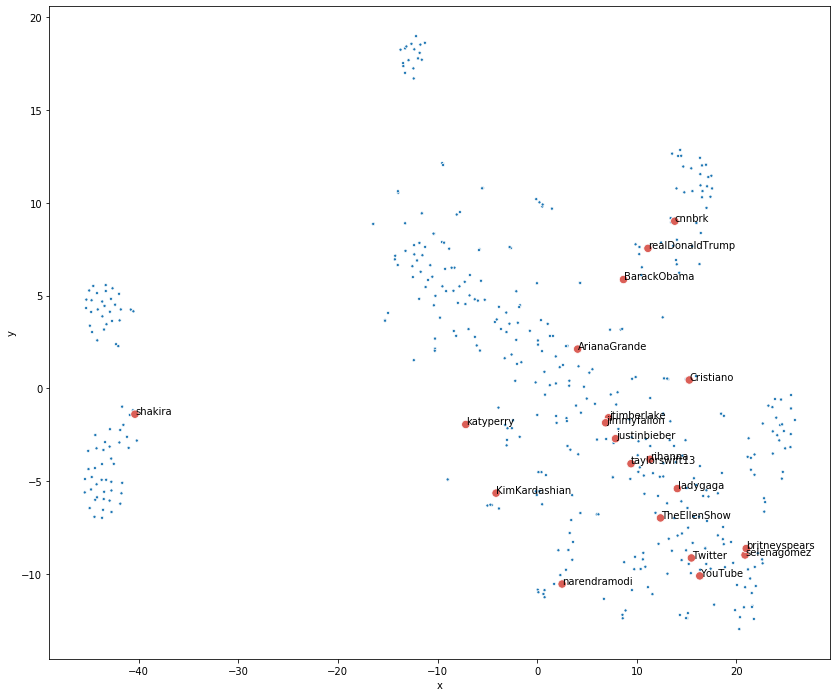

In [11]:
uD = userDetails.reset_index()
uD['isTop20'] = [ ( index< 20 ) for index in uD.index ]

def plot( dataset, x_name, y_name, column, colors='tab10' ):
    plt.figure(figsize=(14,12))
    dataset['label'] = dataset[column]
    color_palette = sns.color_palette(colors, n_colors=1)
    g = sns.scatterplot( x= x_name, y= y_name, hue=column, palette=color_palette, s=10, data= dataset[ dataset['isTop20'] == False ])
    
    dataset2 = dataset[dataset['isTop20'] == True]
    ax = sns.scatterplot( x= x_name, y= y_name, hue=column, palette=sns.color_palette('hls',n_colors=1), s=70, data= dataset2)
    for i in range(20):
        ax.text(dataset.iloc[i]['x']+.02, dataset.iloc[i]['y'], dataset.iloc[i]['Name'])
    g.legend().remove()

plot(uD, 'x', 'y', 'isTop20' )

### <font color='orange'> There isn't a cluster or congolomerate of twitter accounts that we might see in these top 20 accounts! We see total 3 policial leaders : 2 american presidents and an indian prime minister. Rest of those are mostly musicians! Good to see twitter's account in top 20 twiter accounts!</font>

### <font color='blue'>5. Are there some set of words that top 10 accounts use which separate them out from other accounts?</font>

In [12]:
tweets_corpus = [] #we add it in order of users we have in variable twitter_users
for user in all_users:
    all_user_tweets = [ tweet['text'] for tweet in allTweets[user] ]
    tweet_corpus = ' '.join(all_user_tweets)
    tweets_corpus.append( tweet_corpus )
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2), norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [13]:
X = vectorizer.fit_transform(tweets_corpus)
words = vectorizer.get_feature_names()
tfidf = X.todense()

#### Now we got tf-idf frequency of each word for each document! and we know that it *is a statistical measure used to evaluate how important a word is to a document in a collection or corpus*

In [14]:
#all_users is sorted!
words_to_see = 10
user_to_words = {}
for i in range(10):
    user = all_users[i]
    tfidf_value = [ [ tfidf[i][0,j], j ] for j in range(tfidf[i].shape[1]) ]
    tfidf_value.sort(reverse=True)
    mostImportantXWords = [ wd[1] for wd in tfidf_value[0:words_to_see] ]
    user_to_words[ user ] = mostImportantXWords

In [15]:
for user in all_users[0:10]:
    word_indices = user_to_words[user]
    words_ = [ words[i] for i in word_indices ]
    print(user,'\t',words_)

BarackObama 	 ['president obama', 'obama', 'president', 'actonclimate', 'ofa', 'whitehouse', 'doyourjob', 'senate leader', 'live president', 'senate']
justinbieber 	 ['justinbieber', 'purposetour', 'justinbiebers', 'whatdoyoumean', 'purpose', 'bieber', 'justin bieber', 'beliebers', 'justin', 'bkstg']
katyperry 	 ['americanidol', 'kpwww', 'lukebryanonline', 'katyperry', 'lionelrichie', 'love', 'just', 'day', 'neverreallyover', 'witness']
rihanna 	 ['fentybeauty', 'rihanna', 'savagexfenty', 'fentyxpuma', 'navy', 'fentyofficial', 'thank', 'new', 'diamondball', 'stunna']
taylorswift13 	 ['reputation', 'taylornation', 'taylorswift', 'taylor swift', 'brendonurie', 'taylor', 'lover', 'swift', 'taylorswifts', 'thank']
Cristiano 	 ['cristiano', 'madrid', 'hala madrid', 'hala', 'vivaronaldo', 'mercurial', 'nikefootball', 'new', 'game', 'great']
ladygaga 	 ['gaga', 'lady gaga', 'joanne', 'btwfoundation', 'ladygaga', 'lady', 'amp', 'love', 'astarisborn', 'thank']
TheEllenShow 	 ['gameofgames', 'an

### <font color='orange'>For most of the users, the words most important for their tweets is their own names!!!! So people need to keep talking about themselves! Mostly accounts that don't and are still in top 500 may be the news channels!</font>

### <font color='blue'>6. What are most important words for bollywood actors?</font>

In [17]:
u = userDetails[userDetails['region'] == 'india']
top10_indian_actors = list(u[u['category']=='actor'].index)[0:10]

words_to_see = 10
user_to_words_indian_actors = {}
for i in range(len(all_users)):
    user = all_users[i]
    if not(user in top10_indian_actors):
        continue
    tfidf_value = [ [ tfidf[i][0,j], j ] for j in range(tfidf[i].shape[1]) ]
    tfidf_value.sort(reverse=True)
    mostImportantXWords = [ wd[1] for wd in tfidf_value[0:words_to_see] ]
    user_to_words_indian_actors[ user ] = [ words[i] for i in mostImportantXWords ]

In [18]:
for user in top10_indian_actors:
    print(user,'\t',user_to_words_indian_actors[user])

SrBachchan 	 ['janijasmine', 'ashokmistry', 'prashantkawadia', 'swetaloveab', 'vikasm', 'sanjaypatodiya', 'mosessapir', 'srbachchan', 'manishk', 'badla']
BeingSalmanKhan 	 ['uniform serve', 'wear uniform', 'remember need', 'need wear', 'serve country', 'republic day', 'day remember', 'country jai', 'uniform', 'republic']
iamsrk 	 ['thank', 'love', 'raees', 'amp', 'hai', 'thanks', 'toh', 'redchilliesent', 'sejal', 'film']
akshaykumar 	 ['pagla', 'thank', 'support here', 'aapka', 'here', 'padman', 'nahi', 'thank love', 'gaya aapka', 'mad think']
iHrithik 	 ['thank', 'kaabil', 'hrxbrand', 'love', 'thanks', 'hrx', 'rakeshroshann', 'yamigautam', 'ihrithik', 'guy']
deepikapadukone 	 ['deepikapadukone', 'piku', 'tlllfoundation', 'deepika', 'findingfanny', 'tamasha', 'ramleela', 'padukone', 'shoojitsircar', 'deepika padukone']
priyankachopra 	 ['priyankachopra', 'quantico', 'thank', 'love', 'theskyispink', 'teampriyanka', 'happy', 'xoxo', 'lol', 'purplepebblepic']
aamir_khan 	 ['mumkinhai', 'h

### <font color='orange'>This is very interesting!! SrBachchan has mostly names of other people! BeingSalmanKhan's most important words are related to uniform and country, whereas as iamsrk's are thanks and love! Interesting that thanks and love make themselves important words in his tweets! There are many cases of words being movies of those actors or co-starts that worked with them in movies!</font>

### <font color='blue'>7. What are most important words for Indian politicians?</font>

In [19]:
u = userDetails[userDetails['region'] == 'india']
top10_indian_politicians = list(u[u['category']=='politics'].index)[0:5]

words_to_see = 10
user_to_words_indian_politicians = {}
for i in range(len(all_users)):
    user = all_users[i]
    if not(user in top10_indian_politicians):
        continue
    tfidf_value = [ [ tfidf[i][0,j], j ] for j in range(tfidf[i].shape[1]) ]
    tfidf_value.sort(reverse=True)
    mostImportantXWords = [ wd[1] for wd in tfidf_value[0:words_to_see] ]
    user_to_words_indian_politicians[ user ] = [ words[i] for i in mostImportantXWords ]

In [20]:
for user in top10_indian_politicians:
    print(user,'\t',user_to_words_indian_politicians[user])

narendramodi 	 ['india', 'shri', 'thank', 'mannkibaat', 'greeting', 'bjp', 'people', 'president', 'watch', 'yoga']
PMOIndia 	 ['narendramodi', 'india', 'mannkibaat', 'minister', 'shri', 'prime minister', 'called narendramodi', 'met narendramodi', 'prime', 'nnnvia']
AmitShah 	 ['bjpindia', 'shri', 'shri amitshah', 'amitshah', 'narendramodi', 'public meeting', 'amitshahoffice', 'bjpindia live', 'live shri', 'amitshah address']
ArvindKejriwal 	 ['delhi', 'arvindkejriwal', 'aamaadmiparty', 'msisodia', 'govt', 'aap', 'bjp', 'delhi govt', 'atishiaap', 'pankajjainclick']
rajnathsingh 	 ['shri', 'india', 'narendramodi', 'defenceminindia', 'defence', 'minister', 'today', 'greeting', 'new delhi', 'shall']


### <font color='orange'>Most of the important words about politicians are about their names!</font>

### <font color='blue'>8. What are most important words for Top 5 musicians?</font>

In [21]:
top5_musicians = list((userDetails[userDetails['category'] == 'music']).index)[0:5]

words_to_see = 10
user_to_words_musicians = {}
for i in range(len(all_users)):
    user = all_users[i]
    if not(user in top5_musicians):
        continue
    tfidf_value = [ [ tfidf[i][0,j], j ] for j in range(tfidf[i].shape[1]) ]
    tfidf_value.sort(reverse=True)
    mostImportantXWords = [ wd[1] for wd in tfidf_value[0:words_to_see] ]
    user_to_words_musicians[ user ] = [ words[i] for i in mostImportantXWords ]

In [22]:
for user in top5_musicians:
    print(user,'\t',user_to_words_musicians[user])

justinbieber 	 ['justinbieber', 'purposetour', 'justinbiebers', 'whatdoyoumean', 'purpose', 'bieber', 'justin bieber', 'beliebers', 'justin', 'bkstg']
katyperry 	 ['americanidol', 'kpwww', 'lukebryanonline', 'katyperry', 'lionelrichie', 'love', 'just', 'day', 'neverreallyover', 'witness']
rihanna 	 ['fentybeauty', 'rihanna', 'savagexfenty', 'fentyxpuma', 'navy', 'fentyofficial', 'thank', 'new', 'diamondball', 'stunna']
taylorswift13 	 ['reputation', 'taylornation', 'taylorswift', 'taylor swift', 'brendonurie', 'taylor', 'lover', 'swift', 'taylorswifts', 'thank']
ladygaga 	 ['gaga', 'lady gaga', 'joanne', 'btwfoundation', 'ladygaga', 'lady', 'amp', 'love', 'astarisborn', 'thank']


### <font color='orange'>Nothing interesting! Similar to what we saw for top 10 twitter accounts</font>

### <font color='blue'>9. What are most important words for Top 5 news accounts?</font>

In [23]:
top5_news = list((userDetails[userDetails['category'] == 'news']).index)[0:5]

words_to_see = 10
user_to_words_new = {}
for i in range(len(all_users)):
    user = all_users[i]
    if not(user in top5_news):
        continue
    tfidf_value = [ [ tfidf[i][0,j], j ] for j in range(tfidf[i].shape[1]) ]
    tfidf_value.sort(reverse=True)
    mostImportantXWords = [ wd[1] for wd in tfidf_value[0:words_to_see] ]
    user_to_words_new[ user ] = [ words[i] for i in mostImportantXWords ]

In [25]:
for user in top5_news:
    print(user,'\t',user_to_words_new[user])

cnnbrk 	 ['cnnpolitics', 'trump', 'president trump', 'president', 'coronavirus', 'say', 'impeachment', 'cnnbusiness', 'new', 'police']
CNN 	 ['coronavirus', 'gov', 'president trump', 'trump', 'president', 'new', 'state', 'pandemic', 'coronavirus pandemic', 'say']
nytimes 	 ['coronavirus', 'pandemic', 'new', 'briefing here', 'trump', 'coronavirus pandemic', 'president trump', 'new york', 'york', 'people']
BBCBreaking 	 ['bbcsport', 'say', 'police', 'brexit', 'trump', 'president', 'theresa', 'people', 'mp', 'died']
BBCWorld 	 ['coronavirus', 'bbcnews', 'bbcsport', 'bbcbreaking', 'bbcworldservice', 'lockdown', 'bbcnorthamerica', 'trump', 'outbreak', 'bbcafrica']


### <font color='orange'>Most of them are talking about coronavirus and the president trump! Interesting to see word 'new' in there too! BBCWorld seems to be promoting it's own other BBC channels</font>

### <font color='blue'>10. What are most important words for Top 5 INDIAN news accounts?</font>

In [27]:
uD = userDetails[userDetails['category'] == 'news']
top5_indian_news = list((uD[uD['region'] == 'india']).index)[0:5]

words_to_see = 10
user_to_words_indian_news = {}
for i in range(len(all_users)):
    user = all_users[i]
    if not(user in top5_indian_news):
        continue
    tfidf_value = [ [ tfidf[i][0,j], j ] for j in range(tfidf[i].shape[1]) ]
    tfidf_value.sort(reverse=True)
    mostImportantXWords = [ wd[1] for wd in tfidf_value[0:words_to_see] ]
    user_to_words_indian_news[ user ] = [ words[i] for i in mostImportantXWords ]

In [28]:
for user in top5_indian_news:
    print(user,'\t',user_to_words_indian_news[user])

timesofindia 	 ['covid', 'toisports', 'nnread', 'lockdown', 'coronavirus', 'case', 'cautionyespanicno', 'india', 'coronavirusoutbreak', 'toiworld']
ndtv 	 ['gadget', 'coronavirus', 'coronaviruslockdown', 'covid', 'amid', 'lockdown', 'india', 'coronavirusoutbreak', 'sportsndtv', 'delhi']
aajtak 	 ['natvideo', 'lockdown', 'corona', 'coronavirus', 'nlockdown', 'ncoronavirus', 'delhi', 'mumbaitak', 'uttarpradesh', 'dangal']
ABPNews 	 ['coronavirus', 'lockdown', 'covid', 'abp', 'breakingnews', 'nnreport', 'coronavirusinindia', 'coronavirusoutbreak', 'nnwatch', 'india']
TimesNow 	 ['breaking', 'timesnowsports', 'covid', 'lockdown', 'amp', 'india', 'now', 'rahulgandhi', 'tell rahul', 'navika']


### <font color='orange'>Most of them are talking about coronavirus! Super interesting to see TimesNow talking about rahul gandhi!!!!</font>